In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import os
from tqdm.auto import tqdm
import shutil
import random
import cv2
import glob

In [2]:
!unzip -qn '/content/data1.zip' #descomprimimos los datos

In [3]:
df = pd.DataFrame(columns=['ruta', 'categoria']) #crea dataframe con 4 columnas
categorias = ["papel_carton", "plastico"] #categorias del dataset
for num, label in tqdm(enumerate(categorias)): #itera sobre cada categoria para leer las imagenes
  images_path = glob.glob("/content/data1/"+label+"/*") #obtiene el path de las imagenes
  for idx in range(len(images_path)): # agrega la ruta, categoria, en un registro del dataframe
    df = df.append({'ruta': images_path[idx], 'categoria': num}, ignore_index=True)
df #muestra dataframe

0it [00:00, ?it/s]

,ruta,categoria
0,/content/data1/papel_carton/0706042422.jpg,0
1,/content/data1/papel_carton/0706011615.jpg,0
2,/content/data1/papel_carton/0705223910.jpg,0
3,/content/data1/papel_carton/0706004002.jpg,0
4,/content/data1/papel_carton/0706004558.jpg,0
...,...,...
1971,/content/data1/plastico/0706005408.jpg,1
1972,/content/data1/plastico/0706011928.jpg,1
1973,/content/data1/plastico/0706003444.jpg,1
1974,/content/data1/plastico/0706013228.jpg,1


Text(0.5, 1.0, 'CANTIDAD DE IMAGENES POR CATEGORIA EN TRAIN')

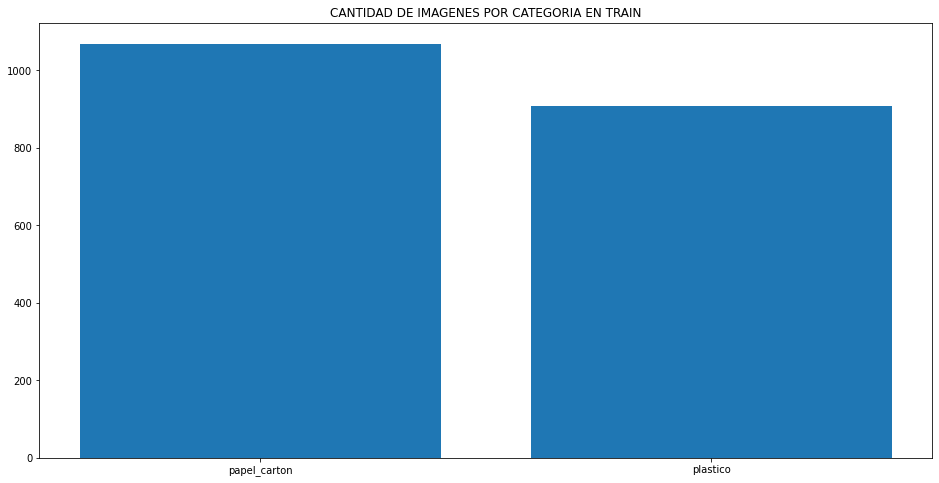

In [7]:
train_y = [] 
for i in range(len(categorias)): # itera sobre las categorias del dataset train
  is_class = df.loc[:, 'categoria'] == i #selecciona la categoria correcta en el dataframe
  df_class = df.loc[is_class] #copia la categoria en un nuevo dataframe
  train_y.append(len(df_class)) #almacena la longitud de la categoria

#muestra grafico de barras
f, ax = plt.subplots(1, 1, figsize=(16,8))
ax.bar(categorias, train_y)
ax.set_title('CANTIDAD DE IMAGENES POR CATEGORIA EN TRAIN')

In [8]:
TRAINSET_PATH = "/content/train1_data"
VALIDSET_PATH = "/content/valid1_data"
TESTSET_PATH = "/content/test1_data"

# Dividir el conjunto de datos en subconjuntos de entrenamiento, validación y prueba con Scikit-learn
train, test = train_test_split(df, test_size=0.15) #15% para test
train, valid = train_test_split(train, test_size=0.17) #17% para validacion
train["image_path"] = " "
test["image_path"] = " "
valid["image_path"] = " "

def sort_subset(subset, target_path):
  ''' Esta función distribuye las imágenes desde una carpeta hacia múltiples
      carpetas, esto en base a las categorías a las que pertenecen las imágenes. 
  '''
  # Comprobar si las nuevas carpetas para el dataset organizado ya fueron creadas
  if os.path.exists(target_path):
    !rm -rf "$target_path"

  !mkdir "$target_path"
  dirs = {}

  # Mover cada imagen a su carpeta respectiva
  for idx, category in enumerate(categorias): 
    !mkdir "$target_path/$category"
    dirs[idx] = target_path+"/"+category

  for idx, sample in tqdm(subset.iterrows(), total=len(subset)):
    image_name = subset.at[idx,"ruta"]
    category = subset.at[idx,"categoria"]

    new_path = dirs[category]+"/"+image_name[-10:]

    shutil.copy(image_name,new_path)  
    subset.at[idx,"image_path"] = new_path
  
  print("Done! ",target_path)
  return subset

train = sort_subset(train,TRAINSET_PATH)
valid = sort_subset(valid,VALIDSET_PATH)
test = sort_subset(test,TESTSET_PATH)
train = train.reset_index()
valid = valid.reset_index()
test = test.reset_index()
#  Mostrar la nueva organización de carpetas en las carpetas train_data y test_data
print(os.listdir(TRAINSET_PATH))
print(os.listdir(VALIDSET_PATH))
print(os.listdir(TESTSET_PATH))

  0%|          | 0/1393 [00:00<?, ?it/s]

Done!  /content/train1_data


  0%|          | 0/286 [00:00<?, ?it/s]

Done!  /content/valid1_data


  0%|          | 0/297 [00:00<?, ?it/s]

Done!  /content/test1_data
['papel_carton', 'plastico']
['papel_carton', 'plastico']
['papel_carton', 'plastico']


In [15]:
print("Número de instancias para el subconjunto de entrenamiento:", len(train))
print("Número de instancias para el subconjunto de validación:", len(valid))
print("Número de instancias para el subconjunto de evaluación:", len(test))

Número de instancias para el subconjunto de entrenamiento: 1393
Número de instancias para el subconjunto de validación: 286
Número de instancias para el subconjunto de evaluación: 297


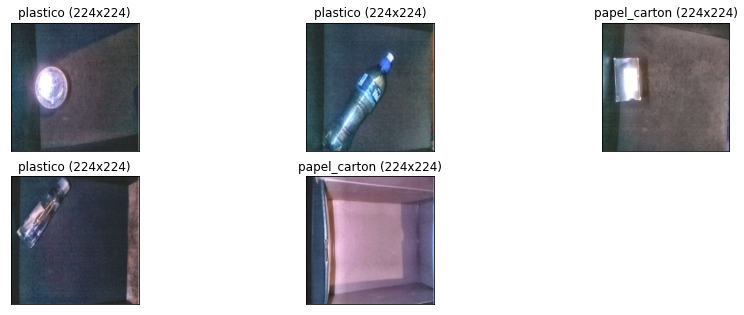

In [12]:
#funcion que grafica 5 imagenes aleatoreas del dataset
def visualize(image_array):
  plt.rcParams["figure.figsize"] = (15,8) 

  for index, sample in enumerate(image_array):
    img = cv2.imread(sample[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, index+1), plt.imshow(img)
    plt.title(sample[1]+" ("+str(img.shape[0])+"x"+str(img.shape[1])+")")
    plt.xticks([]), plt.yticks([])

random_category = random.randint(0,len(categorias)-1)
images = []
num_images = 5

for num in range(num_images):
  random_image = random.randint(0,len(train)-1)
  images.append([train.at[random_image,"ruta"],categorias[train.at[random_image,"categoria"]]])

visualize(images)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Todas las imágenes seran divididas entre el maximo valor por canal, por lo que quedaran rescaladas entre el 0 y 1. 
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Tamaño del lote (imágenes a procesar por el modelo al mismo tiempo)

VALIDSET_PATH = "/content/valid1_data"
TESTSET_PATH = "/content/test1_data"
# Importar datos desde los directorios y convertirlos en lotes de tensores
train_data = train_datagen.flow_from_directory(TRAINSET_PATH,
                                               batch_size=54, # tamaño del lote
                                               target_size=(224, 224), # convertir todas las imágenes a 224 x 224
                                               class_mode="categorical", # mas de 2 'categorical', usar 'binary' si tuviesemos dos clases
                                               seed=42) # semilla para generar las mismas selecciones durante los experimentos
valid_data = valid_datagen.flow_from_directory(VALIDSET_PATH,
                                               batch_size=9,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(TESTSET_PATH,
                                               batch_size=9,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 1393 images belonging to 2 classes.
Found 286 images belonging to 2 classes.
Found 297 images belonging to 2 classes.


In [14]:
# Crear datos sintéticos
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=40, # Nota: esta y las siguientes 4 líneas definen como se crearan nuevas instancias
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode='nearest')
train_data_augmented = train_datagen_augmented.flow_from_directory(TRAINSET_PATH,
                                                                  target_size=(224, 224),
                                                                  batch_size=54,
                                                                  class_mode='categorical')

Found 1393 images belonging to 2 classes.


In [17]:
model1 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True) #importamos el modelo
model1.summary()

14548992/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [20]:
# hacer una referencia a la capa de entrada de VGG
inp = model1.input
# hacer una nueva capa softmax con 2 neuronas
new_classification_layer = tf.keras.layers.Dense(2, activation='softmax')
# conecta la nueva capa a la penúltima capa en mobilenet y hace una referencia a ella
out = new_classification_layer(model1.layers[-2].output)
# crear una nueva red entre inp y out
model_new = tf.keras.Model(inp, out)

In [21]:
# hacer que todas las capas no se puedan entrenar congelando pesos (excepto la última capa)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False
# verifica que la última capa sea entrenable/no congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy', #'categorical_crossentropy'
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [23]:
#entrenamos el modelo
history = model_new.fit(train_data_augmented, 
                          epochs=10,
                          steps_per_epoch=6,
                          validation_data=valid_data,
                          validation_steps=6)

Epoch 1/10
6/6 [==============================] - 17s 791ms/step - loss: 0.7841 - accuracy: 0.5525 - val_loss: 0.5135 - val_accuracy: 0.7963
Epoch 2/10
6/6 [==============================] - 4s 634ms/step - loss: 0.4966 - accuracy: 0.7840 - val_loss: 0.3544 - val_accuracy: 0.8704
Epoch 3/10
6/6 [==============================] - 4s 644ms/step - loss: 0.3429 - accuracy: 0.8580 - val_loss: 0.3244 - val_accuracy: 0.8704
Epoch 4/10
6/6 [==============================] - 4s 636ms/step - loss: 0.2954 - accuracy: 0.8889 - val_loss: 0.1111 - val_accuracy: 0.9815
Epoch 5/10
6/6 [==============================] - 4s 633ms/step - loss: 0.2129 - accuracy: 0.9167 - val_loss: 0.1400 - val_accuracy: 0.9444
Epoch 6/10
6/6 [==============================] - 4s 646ms/step - loss: 0.2012 - accuracy: 0.9297 - val_loss: 0.0990 - val_accuracy: 0.9815
Epoch 7/10
6/6 [==============================] - 4s 609ms/step - loss: 0.1665 - accuracy: 0.9489 - val_loss: 0.1184 - val_accuracy: 0.9259
Epoch 8/10
6/6 [===

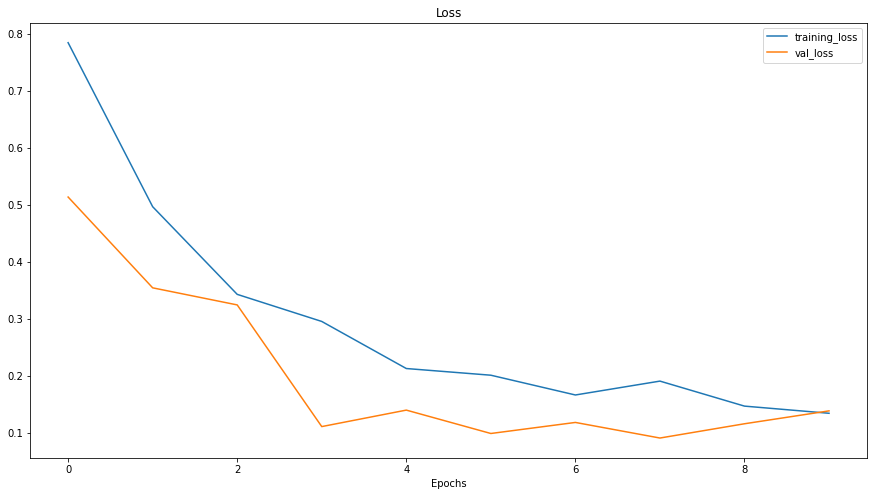

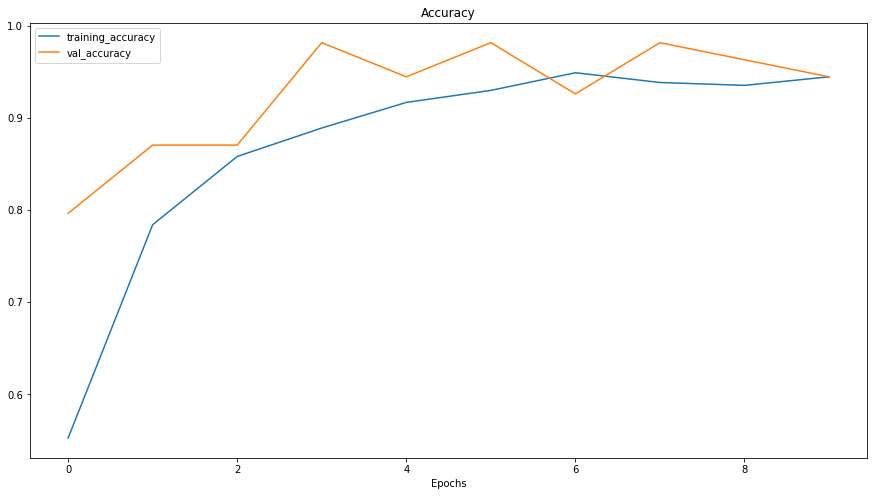

In [24]:
def plot_loss_accuracy_curves(history):
    """
    Devuelve curvas de pérdida separadas para métricas de entrenamiento y validación
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Graficar perdida (Loss)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Graficar presición (accuracy)
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_loss_accuracy_curves(history)

In [25]:
#SE CALCULA EL ACCURACY CON EL NUEVO MODELO 
loss, accuracy = model_new.evaluate(test_data)
print('Accuracy o precision con los datos de evaluacion o test: {:.3%}'.format(accuracy))

33/33 [==============================] - 1s 35ms/step - loss: 0.1227 - accuracy: 0.9529
Accuracy o precision con los datos de evaluacion o test: 95.286%


In [26]:
#METRICA LOG LOSS
from sklearn.metrics import log_loss
predictions = []
labels = []
for i in tqdm(range(test_data.__len__())):
    imgs , label= test_data.__getitem__(i)
    for j in range(len(imgs)):
        prediction = tf.squeeze(model_new.predict(tf.expand_dims(imgs[j], axis=0)))
        predictions.append(prediction)
        labels.append(tf.math.argmax(label[j]).numpy())

logloss = log_loss(labels, predictions)
print("log loss score en toda la data test: ", logloss)

  0%|          | 0/33 [00:00<?, ?it/s]

log loss score en toda la data test:  0.12270061440314307


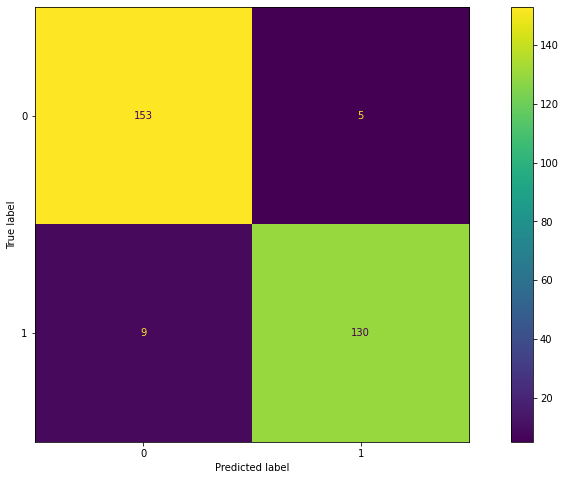

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
pred = tf.math.argmax(predictions,1)
#muestra matriz de confusion
disp = ConfusionMatrixDisplay.from_predictions(labels, pred)

In [29]:
#METRICA F1 SCORE RECALL
import sklearn.metrics as metrics
f1_score = metrics.classification_report(labels, pred)
print(f1_score)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       158
           1       0.96      0.94      0.95       139

    accuracy                           0.95       297
   macro avg       0.95      0.95      0.95       297
weighted avg       0.95      0.95      0.95       297



In [32]:
#EXPORTAMOS EL MODELO
export_dir = 'saved_model'
tf.saved_model.save(model_new, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)                           
tflite_model = converter.convert()
tflite_model_file = 'model_lite.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# Cargar el modelo TFLite y ver algunos detalles sobre la entrada/salida
tflite_interpreter = tf.lite.Interpreter(model_path="/content/model_lite.tflite")

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Datos de entrada ==")
print("Nombre:", input_details[0]['name'])
print("Tamaño:", input_details[0]['shape'])
print("Tipo de datos:", input_details[0]['dtype'])

print("\n== Datos de salida ==")
print("Nombre:", output_details[0]['name'])
print("Tamaño:", output_details[0]['shape'])
print("Tipo de datos:", output_details[0]['dtype'])

== Datos de entrada ==
Nombre: serving_default_keras_layer_input:0
Tamaño: [  1 224 224   3]
Tipo de datos: <class 'numpy.float32'>

== Datos de salida ==
Nombre: StatefulPartitionedCall:0
Tamaño: [1 2]
Tipo de datos: <class 'numpy.float32'>
